# Evaluation: DeepTyper Predictions in Automated Unit Test Generation for Python

In [1]:
import json
import pathlib
import pprint
import statistics
from typing import List, Tuple, Dict, Optional

from bisect import bisect_left
from matplotlib import ticker
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pylatex
import scipy.stats as ss
import seaborn as sns
from pylatex.utils import bold

### Useful Functions for Evaluation

In [2]:
#run -i "merge_statistics_csv.py" ./merge/ ./results.csv

Implement the Vargha and Delaney (Â12) effect size statistics, taken from a [GitHub](https://gist.github.com/jacksonpradolima/f9b19d65b7f16603c837024d5f8c8a65) Gist.

In [3]:
def vd_a(treatment: List[float], control: List[float]) -> Tuple[float, str]:
    """Compute Vargha and Delaney A index

    A. Vargha and H. D. Delaney.  A critique and improvement of the CL common language
    effect size statistics of McGraw and Wong.  Journal of Educational and Behavioral
    Statistics, 25(2):101-132, 2000.

    The formula to compute A has been transformed to minimise accuracy errors, see
    https://mtorchiano.wordpress.com/2014/05/19/effect-size-of-r-precision/

    :param treatment: a list of numbers
    :param control: a list of numbers
    :return: the value estimate and the magnitude
    """
    m = len(treatment)
    n = len(control)

    #if m != n:
    #    raise ValueError("Parameter lists must have equal lengths")

    r = ss.rankdata(treatment + control)
    r1 = sum(r[0:m])

    # Compute the measure
    # A = (r1/m - (m+1)/2)/n  # formula (14) in Vargha and Delaney, 2000
    A = (2 * r1 - m * (m + 1)) / (2 * n * m)  # equivalent formula with better accuracy

    levels = [0.147, 0.33, 0.474]
    magnitudes = ["negligible", "small", "medium", "large"]
    scaled_A = (A - 0.5) * 2

    magnitude = magnitudes[bisect_left(levels, abs(scaled_A))]
    estimate = A

    return estimate, magnitude

### Load Data from CSV Files

In [4]:
# The names of the columns we are interested in
cut = "TargetModule"
project_name = "ProjectName"
config = "ConfigurationId"
coverage = "Coverage"
seconds = [f"CoverageTimeline_T{i}" for i in range(1, 601)]
use_cols = [cut, project_name, config, coverage] + seconds

sns.set_style(style="whitegrid")
matplotlib.use("pgf")

# How often every CUT was executed
runs = 30

SIGNIFICANT_P = 0.05

result_file = pathlib.Path(".") / "results.csv"
results = pd.read_csv(result_file)

PAPER_EXPORT_PATH = pathlib.Path(
    "."
)

# Extract modules executed 30 times for each configuration
counts = results[cut].value_counts()
results = results[results[cut].isin(counts[counts == runs * 5].index)]

### Quick Overview

In [5]:
results.groupby(config)[coverage].describe()

,count,mean,std,min,25%,50%,75%,max
ConfigurationId,,,,,,,,
no_deeptyper,2340.0,0.789474,0.288381,0.037975,0.666667,0.969697,1.0,1.0
rt0.1_rndch,2340.0,0.796342,0.285775,0.037975,0.692308,0.970960,1.0,1.0
rt0.2_rndch,2340.0,0.794554,0.287686,0.037975,0.692308,0.969697,1.0,1.0
rt0.3_rndch,2340.0,0.795095,0.287045,0.037975,0.692308,0.970960,1.0,1.0
rt0_rndch,2340.0,0.794086,0.287780,0.037975,0.692308,0.970960,1.0,1.0


In [6]:
mcp = results.groupby([config, project_name], as_index=False).agg(
    {
        coverage: "mean",
    }
)

nmp = [1,1,1,3,7,2,16,15,7,5,1,5,10,3,1]
ps = results.ProjectName.unique().tolist()
ps.sort()
cs = ['no_deeptyper', 'rt0_rndch', 'rt0.1_rndch', 'rt0.2_rndch', 'rt0.3_rndch']

table1 = pylatex.Tabular('lcccccc')
table1.add_row(bold("Projekt"), bold("#Module"), pylatex.MultiColumn(5, align='c', data=bold('%Coverage')),)
table1.add_row("", "",  "Baseline","RT0", "RT10", "RT20", "RT30")
table1.add_hline()
i = 0
for p in ps:
    vals = []
    for c in cs:
        vals.append(mcp.loc[(mcp.ConfigurationId == c) & (mcp.ProjectName == p), "Coverage"].item())
    table1.add_row(p, nmp[i], "{:.2f}".format(vals[0]), "{:.2f}".format(vals[1]), "{:.2f}".format(vals[2]), "{:.2f}".format(vals[3]), "{:.2f}".format(vals[4]))
    i += 1
print(table1.dumps())

\begin{tabular}{lcccccc}%
\textbf{Projekt}&\textbf{\#Module}&\multicolumn{5}{c}{\textbf{\%Coverage}}\\%
&&Baseline&RT0&RT10&RT20&RT30\\%
\hline%
dataclasses{-}json&1&0.88&0.88&0.88&0.88&0.88\\%
docstring\_parser&1&0.86&0.90&0.90&0.90&0.90\\%
flutes&1&1.00&1.00&1.00&1.00&1.00\\%
flutils&3&0.38&0.37&0.38&0.37&0.39\\%
httpie&7&0.68&0.68&0.68&0.68&0.68\\%
isort&2&0.98&0.98&0.98&0.98&0.98\\%
mimesis&16&1.00&1.00&1.00&1.00&1.00\\%
py{-}backwards&15&0.61&0.63&0.64&0.63&0.63\\%
pyMonet&7&0.79&0.79&0.79&0.79&0.79\\%
pypara&5&0.87&0.87&0.87&0.87&0.87\\%
python{-}string{-}utils&1&1.00&1.00&1.00&1.00&1.00\\%
pytutils&5&0.72&0.72&0.72&0.72&0.72\\%
sanic&10&0.74&0.75&0.75&0.75&0.75\\%
sty&3&1.00&1.00&1.00&1.00&1.00\\%
thonny&1&1.00&1.00&1.00&1.00&1.00\\%
\end{tabular}


In [7]:
#Number of modules per project
results.groupby(project_name)[cut].nunique()

ProjectName
dataclasses-json        1
docstring_parser        1
flutes                  1
flutils                 3
httpie                  7
isort                   2
mimesis                16
py-backwards           15
pyMonet                 7
pypara                  5
python-string-utils     1
pytutils                5
sanic                  10
sty                     3
thonny                  1
Name: TargetModule, dtype: int64

In [8]:
number_cuts = len(set(results[cut]))
print("Tested classes:")
print(set(results[cut]))
print(f"I tested {number_cuts} unique classes, each being executed {runs} times per "
      f"configuration")

Tested classes:
{'mimesis.shortcuts', 'mimesis.builtins.it', 'pymonet.semigroups', 'mimesis.providers.transport', 'flutils.packages', 'mimesis.providers.hardware', 'mimesis.providers.clothing', 'isort.comments', 'sanic.mixins.middleware', 'py_backwards.transformers.metaclass', 'mimesis.builtins.de', 'pypara.accounting.generic', 'sanic.headers', 'pytutils.debug', 'docstring_parser.parser', 'mimesis.exceptions', 'sanic.handlers', 'sanic.helpers', 'sanic.views', 'py_backwards.transformers.import_pathlib', 'pypara.commons.errors', 'sty.register', 'mimesis.providers.development', 'pytutils.lazy.simple_import', 'isort.exceptions', 'sanic.mixins.signals', 'py_backwards.transformers.formatted_values', 'pypara.commons.zeitgeist', 'py_backwards.transformers.variables_annotations', 'mimesis.builtins.uk', 'pymonet.monad_try', 'sty.lib', 'mimesis.builtins.pt_br', 'sanic.models.futures', 'flutils.strutils', 'pytutils.props', 'mimesis.builtins.base', 'sanic.base', 'mimesis.builtins.da', 'pypara.commo

In [9]:
config_names = list(set(results[config]))
config_names.sort()
print("I used {} configurations, namely:\n - {}".format(
    len(config_names), "\n - ".join(config_names)
))
print("no_deeptyper (Baseline): Default settings and developer-added annotations are used by Pynguin")
print("rtX_rndch (short: RTX): Default settings and use of top-5 deeptyper predictions (weighted choice) with a random type probability of X")

I used 5 configurations, namely:
 - no_deeptyper
 - rt0.1_rndch
 - rt0.2_rndch
 - rt0.3_rndch
 - rt0_rndch
no_deeptyper (Baseline): Default settings and developer-added annotations are used by Pynguin
rtX_rndch (short: RTX): Default settings and use of top-5 deeptyper predictions (weighted choice) with a random type probability of X


In [10]:
ticks = list(set(results[project_name].values))
ticks.sort()

def set_box_colour(bp, colour):
    plt.setp(bp["boxes"], color=colour)
    plt.setp(bp["whiskers"], color=colour)
    plt.setp(bp["caps"], color=colour)
    plt.setp(bp["medians"], color=colour)

def get_result_lists(left_config: str, right_config: str) -> Tuple[List[pd.Series], List[pd.Series]]:
    bpl_dfs = []
    bpr_dfs = []
    for project in ticks:
        bpl_df = results[results[project_name] == project].groupby(config).get_group(
            left_config
        )["Coverage"]
        bpr_df = results[results[project_name] == project].groupby(config).get_group(
            right_config
        )["Coverage"]
        bpl_dfs.append(bpl_df)
        bpr_dfs.append(bpr_df)
    return bpl_dfs, bpr_dfs

def get_result_lists5(config1: str, config2: str, config3: str, config4: str, config5: str) -> Tuple[List[pd.Series], List[pd.Series]]:
    bp1_dfs = []
    bp2_dfs = []
    bp3_dfs = []
    bp4_dfs = []
    bp5_dfs = []
    for project in ticks:
        bp1_df = results[results[project_name] == project].groupby(config).get_group(
            config1
        )["Coverage"]
        bp2_df = results[results[project_name] == project].groupby(config).get_group(
            config2
        )["Coverage"]
        bp3_df = results[results[project_name] == project].groupby(config).get_group(
            config3
        )["Coverage"]
        bp4_df = results[results[project_name] == project].groupby(config).get_group(
            config4
        )["Coverage"]
        bp5_df = results[results[project_name] == project].groupby(config).get_group(
            config5
        )["Coverage"]
        bp1_dfs.append(bp1_df)
        bp2_dfs.append(bp2_df)
        bp3_dfs.append(bp3_df)
        bp4_dfs.append(bp4_df)
        bp5_dfs.append(bp5_df)
    return bp1_dfs, bp2_dfs, bp3_dfs, bp4_dfs, bp5_dfs

### Comparison of all configurations

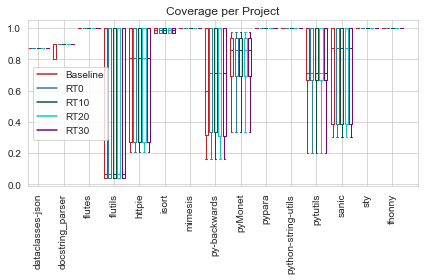

In [11]:
%matplotlib inline
plt.figure()
plt.title("Coverage per Project")

bp1_dfs, bp2_dfs, bp3_dfs, bp4_dfs, bp5_dfs = get_result_lists5("no_deeptyper", "rt0_rndch", "rt0.1_rndch", "rt0.2_rndch", "rt0.3_rndch")
bp1 = plt.boxplot(
    bp1_dfs,
    positions=np.array(range(len(ticks))) * 5.0 - 1.8,
    sym="",
    widths=0.6,
)
bp2 = plt.boxplot(
    bp2_dfs,
    positions=np.array(range(len(ticks))) * 5.0 - 0.9,
    sym="",
    widths=0.6,
)
bp3 = plt.boxplot(
    bp3_dfs,
    positions=np.array(range(len(ticks))) * 5.0 + 0,
    sym="",
    widths=0.6,
)     
bp4 = plt.boxplot(
    bp4_dfs,
    positions=np.array(range(len(ticks))) * 5.0 + 0.9,
    sym="",
    widths=0.6,
)   
bp5 = plt.boxplot(
    bp5_dfs,
    positions=np.array(range(len(ticks))) * 5.0 + 1.8,
    sym="",
    widths=0.6,
)   
set_box_colour(bp1, "#D7191C")
set_box_colour(bp2, "#2C7BB6")
set_box_colour(bp3, "#065535")
set_box_colour(bp4, "#00ced1")
set_box_colour(bp5, "#800080")

plt.plot([], c="#D7191C", label="Baseline")
plt.plot([], c="#2C7BB6", label="RT0")
plt.plot([], c="#065535", label="RT10")
plt.plot([], c="#00ced1", label="RT20")
plt.plot([], c="#800080", label="RT30")
plt.legend()

plt.xticks(range(0, len(ticks) * 5, 5), ticks, rotation=90)
plt.xlim(-2, len(ticks) * 5)
plt.tight_layout()
plt.savefig(PAPER_EXPORT_PATH / "." / "coverage-all-configs.pdf", bbox_inches="tight")
plt.show()

Except for the docstring_parser project, no major differences between the configurations.
In the case of docstring_parser the only difference is that the use of DeepTyper predictions leads more often to an exception than by the No-DeepTyper config through which the except-branch is also covered.

In [12]:
def compute_data_for_effect_sizes(
    control_configuration: str,
    treatment_configuration: str,
) -> Dict[str, Dict[str, Tuple[List[float], List[float]]]]:
    data_per_project = {}
    for project in ticks:
        treatment = results[
            (results[config] == treatment_configuration)
            & (results[project_name] == project)
        ]
        control = results[
            (results[config] == control_configuration)
            & (results[project_name] == project)
        ]
        module_data = {}
        for module in set(control[cut].tolist()):
            control_values = control[
                control[cut] == module
            ][coverage].values.tolist()
            treatment_values = treatment[
                treatment[cut] == module
            ][coverage].values.tolist()
            if len(treatment_values) != len(control_values):
                z = min(len(control_values), len(treatment_values))
                control_values = control_values[:z]
                treatment_values = treatment_values[:z]
            module_data[module] = (control_values, treatment_values)
        data_per_project[project] = module_data
    return data_per_project

### No-DeepTyper vs. Random-Type-0

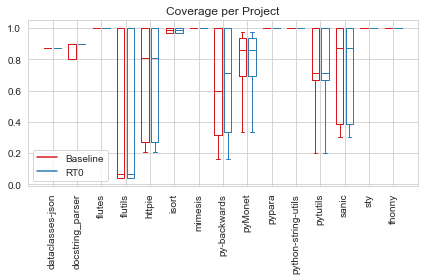

In [13]:
plt.figure()
plt.title("Coverage per Project")

bpl_dfs, bpr_dfs = get_result_lists("no_deeptyper", "rt0_rndch")
bpl = plt.boxplot(
    bpl_dfs,
    positions=np.array(range(len(ticks))) * 2.0 - 0.4,
    sym="",
    widths=0.6,
)
bpr = plt.boxplot(
    bpr_dfs,
    positions=np.array(range(len(ticks))) * 2.0 + 0.4,
    sym="",
    widths=0.6,
)
set_box_colour(bpl, "#D7191C")
set_box_colour(bpr, "#2C7BB6")

plt.plot([], c="#D7191C", label="Baseline")
plt.plot([], c="#2C7BB6", label="RT0")
plt.legend()

plt.xticks(range(0, len(ticks) * 2, 2), ticks, rotation=90)
plt.xlim(-2, len(ticks) * 2)
plt.tight_layout()

plt.savefig(PAPER_EXPORT_PATH / "." / "coverage-0.pdf", bbox_inches="tight")
plt.show()

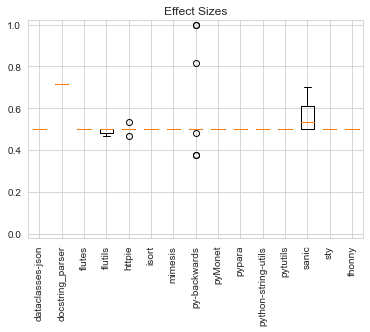

In [14]:
fig, ax = plt.subplots()
plt.title("Effect Sizes")
plt.xticks(rotation=90)
n = 0
effect_size_data = compute_data_for_effect_sizes("rt0_rndch", "no_deeptyper")
for project, project_data in effect_size_data.items():
    effect_sizes = []
    for m, v in project_data.items():
        x, y = v
        try:
            effect_size, _ = vd_a(x, y)
            effect_sizes.append(effect_size)
        except ZeroDivisionError:
            pass
    ax.boxplot(effect_sizes, positions=[n], widths=0.6)
    n += 1
ax.set_xticks(range(len(ticks)))
ax.set_xticklabels(ticks)
ax.set_ylim(-0.02, 1.02)
plt.savefig(PAPER_EXPORT_PATH / "effect-sizes-rt0-ndt.pdf", bbox_inches="tight")
plt.show()

In [15]:
effect_sizes_per_project = {}
mann_whitney_values = {}
for project, project_data in effect_size_data.items():
    controls = []
    treatments = []
    for _, v in project_data.items():
        x, y = v
        controls.extend(x)
        treatments.extend(y)
    effect_sizes_per_project[project] = vd_a(controls, treatments)
    
    try:               
        mann_whitney_values[project] = ss.mannwhitneyu(controls, treatments).pvalue
    except IndexError:
        pass # if for one config the run failed, nothing can be added
    except ValueError:
        mann_whitney_values[project] = 1 # if all values for both strategies are equal
    

for project, effect_size in effect_sizes_per_project.items():
    p_value = mann_whitney_values[project]
    is_significant = "(significant)" if p_value < 0.05 else ""
    print(f"Project {project}")
    print(f"    A12:     {effect_size[0]} ({effect_size[1]})")
    print(f"    p-value: {p_value} {is_significant}")
    print()

Project dataclasses-json
    A12:     0.5 (negligible)
    p-value: 1 

Project docstring_parser
    A12:     0.7166666666666667 (medium)
    p-value: 2.796702054859925e-05 (significant)

Project flutes
    A12:     0.5 (negligible)
    p-value: 1 

Project flutils
    A12:     0.4888888888888889 (negligible)
    p-value: 0.3931813536773408 

Project httpie
    A12:     0.501360544217687 (negligible)
    p-value: 0.48058464001923 

Project isort
    A12:     0.5 (negligible)
    p-value: 0.4987911278257599 

Project mimesis
    A12:     0.5 (negligible)
    p-value: 0.4998892404336936 

Project py-backwards
    A12:     0.5182864197530864 (negligible)
    p-value: 0.1686075582370528 

Project pyMonet
    A12:     0.5 (negligible)
    p-value: 0.4998379733215977 

Project pypara
    A12:     0.5 (negligible)
    p-value: 0.4996167580086846 

Project python-string-utils
    A12:     0.5 (negligible)
    p-value: 1 

Project pytutils
    A12:     0.5 (negligible)
    p-value: 0.4997219670

### No-DeepTyper vs. Random-Type-0.1

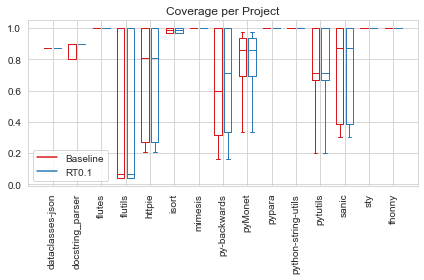

In [16]:
plt.rcParams.update({
    "pgf.texsystem": "pdflatex",
})
plt.figure()
plt.title("Coverage per Project")

bpl_dfs, bpr_dfs = get_result_lists("no_deeptyper", "rt0.1_rndch")
bpl = plt.boxplot(
    bpl_dfs,
    positions=np.array(range(len(ticks))) * 2.0 - 0.4,
    sym="",
    widths=0.6,
)
bpr = plt.boxplot(
    bpr_dfs,
    positions=np.array(range(len(ticks))) * 2.0 + 0.4,
    sym="",
    widths=0.6,
)
set_box_colour(bpl, "#D7191C")
set_box_colour(bpr, "#2C7BB6")

plt.plot([], c="#D7191C", label="Baseline")
plt.plot([], c="#2C7BB6", label="RT0.1")
plt.legend()

plt.xticks(range(0, len(ticks) * 2, 2), ticks, rotation=90)
plt.xlim(-2, len(ticks) * 2)
plt.tight_layout()

plt.savefig(PAPER_EXPORT_PATH / "." / "coverage-0-1.pdf", bbox_inches="tight")
plt.show()

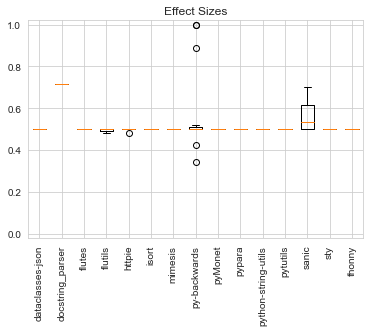

In [17]:
fig, ax = plt.subplots()
plt.title("Effect Sizes")
plt.xticks(rotation=90)
n = 0
effect_size_data = compute_data_for_effect_sizes("rt0.1_rndch", "no_deeptyper")
for project, project_data in effect_size_data.items():
    effect_sizes = []
    for m, v in project_data.items():
        x, y = v
        try:
            effect_size, _ = vd_a(x, y)
            effect_sizes.append(effect_size)
        except ZeroDivisionError:
            pass
    ax.boxplot(effect_sizes, positions=[n], widths=0.6)
    n += 1
ax.set_xticks(range(len(ticks)))
ax.set_xticklabels(ticks)
ax.set_ylim(-0.02, 1.02)
plt.savefig(PAPER_EXPORT_PATH / "effect-sizes-rdt01-ndt.pdf", bbox_inches="tight")
plt.show()

In [18]:
effect_sizes_per_project = {}
mann_whitney_values = {}
for project, project_data in effect_size_data.items():
    controls = []
    treatments = []
    for _, v in project_data.items():
        x, y = v
        controls.extend(x)
        treatments.extend(y)
    effect_sizes_per_project[project] = vd_a(controls, treatments)
    
    try:               
        mann_whitney_values[project] = ss.mannwhitneyu(controls, treatments).pvalue
    except IndexError:
        pass # if for one config the run failed, nothing can be added
    except ValueError:
        mann_whitney_values[project] = 1 # if all values for both strategies are equal
    


for project, effect_size in effect_sizes_per_project.items():
    p_value = mann_whitney_values[project]
    is_significant = "(significant)" if p_value < 0.05 else ""
    print(f"Project {project}")
    print(f"    A12:     {effect_size[0]} ({effect_size[1]})")
    print(f"    p-value: {p_value} {is_significant}")
    print()

Project dataclasses-json
    A12:     0.5 (negligible)
    p-value: 1 

Project docstring_parser
    A12:     0.7166666666666667 (medium)
    p-value: 2.796702054859925e-05 (significant)

Project flutes
    A12:     0.5 (negligible)
    p-value: 1 

Project flutils
    A12:     0.49444444444444446 (negligible)
    p-value: 0.44645097856786753 

Project httpie
    A12:     0.4996598639455782 (negligible)
    p-value: 0.4952672379351997 

Project isort
    A12:     0.5 (negligible)
    p-value: 0.4987911278257599 

Project mimesis
    A12:     0.5 (negligible)
    p-value: 0.4998892404336936 

Project py-backwards
    A12:     0.5268592592592592 (negligible)
    p-value: 0.07931992560584489 

Project pyMonet
    A12:     0.5 (negligible)
    p-value: 0.4998379733215977 

Project pypara
    A12:     0.5 (negligible)
    p-value: 0.4996167580086846 

Project python-string-utils
    A12:     0.5 (negligible)
    p-value: 1 

Project pytutils
    A12:     0.5 (negligible)
    p-value: 0.4997

### No-DeepTyper vs. Random-Type-0.2

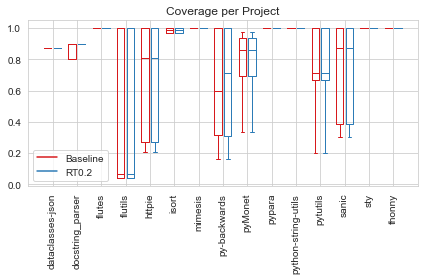

In [19]:
plt.rcParams.update({
    "pgf.texsystem": "pdflatex",
})
plt.figure()
plt.title("Coverage per Project")

bpl_dfs, bpr_dfs = get_result_lists("no_deeptyper", "rt0.2_rndch")
bpl = plt.boxplot(
    bpl_dfs,
    positions=np.array(range(len(ticks))) * 2.0 - 0.4,
    sym="",
    widths=0.6,
)
bpr = plt.boxplot(
    bpr_dfs,
    positions=np.array(range(len(ticks))) * 2.0 + 0.4,
    sym="",
    widths=0.6,
)
set_box_colour(bpl, "#D7191C")
set_box_colour(bpr, "#2C7BB6")

plt.plot([], c="#D7191C", label="Baseline")
plt.plot([], c="#2C7BB6", label="RT0.2")
plt.legend()

plt.xticks(range(0, len(ticks) * 2, 2), ticks, rotation=90)
plt.xlim(-2, len(ticks) * 2)
plt.tight_layout()

plt.savefig(PAPER_EXPORT_PATH / "." / "coverage-0-2.pdf", bbox_inches="tight")
plt.show()

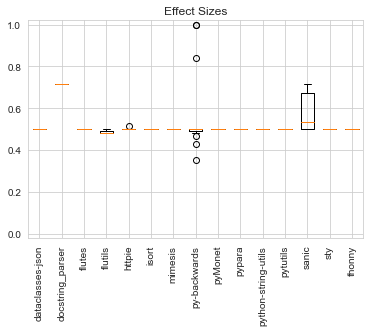

In [20]:
fig, ax = plt.subplots()
plt.title("Effect Sizes")
plt.xticks(rotation=90)
n = 0
effect_size_data = compute_data_for_effect_sizes("rt0.2_rndch", "no_deeptyper")
for project, project_data in effect_size_data.items():
    effect_sizes = []
    for m, v in project_data.items():
        x, y = v
        try:
            effect_size, _ = vd_a(x, y)
            effect_sizes.append(effect_size)
        except ZeroDivisionError:
            pass
    ax.boxplot(effect_sizes, positions=[n], widths=0.6)
    n += 1
ax.set_xticks(range(len(ticks)))
ax.set_xticklabels(ticks)
ax.set_ylim(-0.02, 1.02)
plt.savefig(PAPER_EXPORT_PATH / "effect-sizes-rdt02-ndt.pdf", bbox_inches="tight")
plt.show()

In [21]:
effect_sizes_per_project = {}
mann_whitney_values = {}
for project, project_data in effect_size_data.items():
    controls = []
    treatments = []
    for _, v in project_data.items():
        x, y = v
        controls.extend(x)
        treatments.extend(y)
    effect_sizes_per_project[project] = vd_a(controls, treatments)
    
    try:               
        mann_whitney_values[project] = ss.mannwhitneyu(controls, treatments).pvalue
    except IndexError:
        pass # if for one config the run failed, nothing can be added
    except ValueError:
        mann_whitney_values[project] = 1 # if all values for both strategies are equal
    


for project, effect_size in effect_sizes_per_project.items():
    p_value = mann_whitney_values[project]
    is_significant = "(significant)" if p_value < 0.05 else ""
    print(f"Project {project}")
    print(f"    A12:     {effect_size[0]} ({effect_size[1]})")
    print(f"    p-value: {p_value} {is_significant}")
    print()


Project dataclasses-json
    A12:     0.5 (negligible)
    p-value: 1 

Project docstring_parser
    A12:     0.7166666666666667 (medium)
    p-value: 2.796702054859925e-05 (significant)

Project flutes
    A12:     0.5 (negligible)
    p-value: 1 

Project flutils
    A12:     0.49234567901234566 (negligible)
    p-value: 0.4262706809100225 

Project httpie
    A12:     0.5003401360544217 (negligible)
    p-value: 0.4952676189588579 

Project isort
    A12:     0.5 (negligible)
    p-value: 0.4987911278257599 

Project mimesis
    A12:     0.5 (negligible)
    p-value: 0.4998892404336936 

Project py-backwards
    A12:     0.5168987654320988 (negligible)
    p-value: 0.1875835548388401 

Project pyMonet
    A12:     0.5 (negligible)
    p-value: 0.4998379733215977 

Project pypara
    A12:     0.5 (negligible)
    p-value: 0.4996167580086846 

Project python-string-utils
    A12:     0.5 (negligible)
    p-value: 1 

Project pytutils
    A12:     0.5 (negligible)
    p-value: 0.499721

### No-DeepTyper vs. Random-Type-0.3

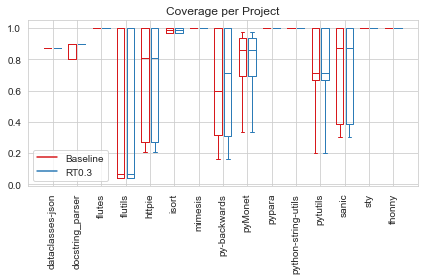

In [22]:
plt.rcParams.update({
    "pgf.texsystem": "pdflatex",
})
plt.figure()
plt.title("Coverage per Project")

bpl_dfs, bpr_dfs = get_result_lists("no_deeptyper", "rt0.3_rndch")
bpl = plt.boxplot(
    bpl_dfs,
    positions=np.array(range(len(ticks))) * 2.0 - 0.4,
    sym="",
    widths=0.6,
)
bpr = plt.boxplot(
    bpr_dfs,
    positions=np.array(range(len(ticks))) * 2.0 + 0.4,
    sym="",
    widths=0.6,
)
set_box_colour(bpl, "#D7191C")
set_box_colour(bpr, "#2C7BB6")

plt.plot([], c="#D7191C", label="Baseline")
plt.plot([], c="#2C7BB6", label="RT0.3")
plt.legend()

plt.xticks(range(0, len(ticks) * 2, 2), ticks, rotation=90)
plt.xlim(-2, len(ticks) * 2)
plt.tight_layout()

plt.savefig(PAPER_EXPORT_PATH / "." / "coverage-0-3.pdf", bbox_inches="tight")
plt.show()

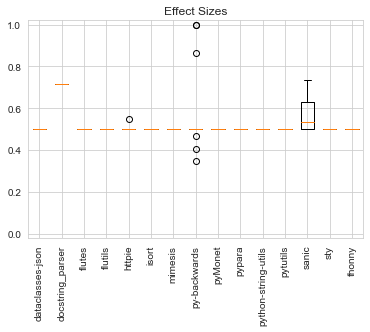

In [23]:
fig, ax = plt.subplots()
plt.title("Effect Sizes")
plt.xticks(rotation=90)
n = 0
effect_size_data = compute_data_for_effect_sizes("rt0.3_rndch", "no_deeptyper")
for project, project_data in effect_size_data.items():
    effect_sizes = []
    for m, v in project_data.items():
        x, y = v
        try:
            effect_size, _ = vd_a(x, y)
            effect_sizes.append(effect_size)
        except ZeroDivisionError:
            pass
    ax.boxplot(effect_sizes, positions=[n], widths=0.6)
    n += 1
ax.set_xticks(range(len(ticks)))
ax.set_xticklabels(ticks)
ax.set_ylim(-0.02, 1.02)
plt.savefig(PAPER_EXPORT_PATH / "effect-sizes-rdt03-ndt.pdf", bbox_inches="tight")
plt.show()

In [24]:
effect_sizes_per_project = {}
mann_whitney_values = {}
for project, project_data in effect_size_data.items():
    controls = []
    treatments = []
    for _, v in project_data.items():
        x, y = v
        controls.extend(x)
        treatments.extend(y)
    effect_sizes_per_project[project] = vd_a(controls, treatments)
    
    try:               
        mann_whitney_values[project] = ss.mannwhitneyu(controls, treatments).pvalue
    except IndexError:
        pass # if for one config the run failed, nothing can be added
    except ValueError:
        mann_whitney_values[project] = 1 # if all values for both strategies are equal
    


for project, effect_size in effect_sizes_per_project.items():
    p_value = mann_whitney_values[project]
    is_significant = "(significant)" if p_value < 0.05 else ""
    print(f"Project {project}")
    print(f"    A12:     {effect_size[0]} ({effect_size[1]})")
    print(f"    p-value: {p_value} {is_significant}")
    print()

Project dataclasses-json
    A12:     0.5 (negligible)
    p-value: 1 

Project docstring_parser
    A12:     0.7166666666666667 (medium)
    p-value: 2.796702054859925e-05 (significant)

Project flutes
    A12:     0.5 (negligible)
    p-value: 1 

Project flutils
    A12:     0.5 (negligible)
    p-value: 0.49939706095692377 

Project httpie
    A12:     0.503061224489796 (negligible)
    p-value: 0.45618499139910235 

Project isort
    A12:     0.5 (negligible)
    p-value: 0.4987911278257599 

Project mimesis
    A12:     0.5 (negligible)
    p-value: 0.4998892404336936 

Project py-backwards
    A12:     0.5172246913580247 (negligible)
    p-value: 0.1830064674556207 

Project pyMonet
    A12:     0.5 (negligible)
    p-value: 0.4998379733215977 

Project pypara
    A12:     0.5 (negligible)
    p-value: 0.4996167580086846 

Project python-string-utils
    A12:     0.5 (negligible)
    p-value: 1 

Project pytutils
    A12:     0.5 (negligible)
    p-value: 0.4997219670169995 

Pr

### Coverage over time

I tested 78 unique classes, each being executed 30 times per configuration
I used 5 configurations, namely:
 - no_deeptyper
 - rt0.1_rndch
 - rt0.2_rndch
 - rt0.3_rndch
 - rt0_rndch
Available Data Points:
----------------------
                  no_deeptyper:   78 / 78 CUTS tested 
                   rt0.1_rndch:   78 / 78 CUTS tested 
                   rt0.2_rndch:   78 / 78 CUTS tested 
                   rt0.3_rndch:   78 / 78 CUTS tested 
                     rt0_rndch:   78 / 78 CUTS tested 


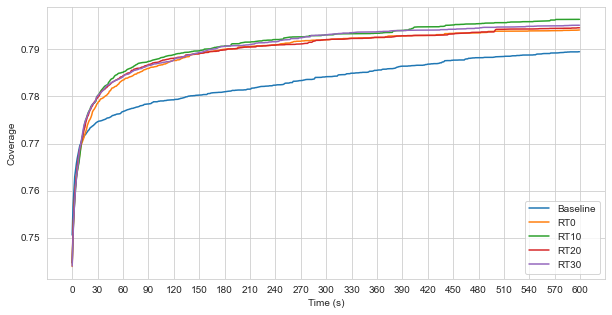

<Figure size 432x288 with 0 Axes>

In [25]:
run -i "plot_coverage_over_time.py"

DeepTyper achieves sligthly higher code coverage than No-DeepTyper.

### Latex Tables

In [26]:
table_data = results.groupby([config, project_name], as_index=False).agg(
    {
        coverage: "mean",
    }
)

cov_values = results.groupby([config, project_name])[coverage].apply(list).reset_index(name='Coverage Values')
cov_values_by_module = results.groupby([config, project_name, cut])[coverage].apply(list).reset_index(name='Coverage Values')


merged = pd.merge(table_data, table_data, on=project_name)
ndt0 = merged.loc[(merged['ConfigurationId_x'] == 'no_deeptyper') & (merged['ConfigurationId_y'] == 'rt0_rndch')]
ndt0.insert(2, "# Modules", [1,1,1,3,7,2,16,15,7,5,1,5,10,3,1], True)

ndt0_1 = merged.loc[(merged['ConfigurationId_x'] == 'no_deeptyper') & (merged['ConfigurationId_y'] == 'rt0.1_rndch')]
ndt0_1.insert(2, "# Modules", [1,1,1,3,7,2,16,15,7,5,1,5,10,3,1], True)

ndt0_2 = merged.loc[(merged['ConfigurationId_x'] == 'no_deeptyper') & (merged['ConfigurationId_y'] == 'rt0.2_rndch')]
ndt0_2.insert(2, "# Modules", [1,1,1,3,7,2,16,15,7,5,1,5,10,3,1], True)

ndt0_3 = merged.loc[(merged['ConfigurationId_x'] == 'no_deeptyper') & (merged['ConfigurationId_y'] == 'rt0.3_rndch')]
ndt0_3.insert(2, "# Modules", [1,1,1,3,7,2,16,15,7,5,1,5,10,3,1], True)

In [27]:
def calc_a12(p: str, strategy1: str, strategy2: str, cov_values: pd.DataFrame):
    treatment_row = cov_values.loc[(cov_values['ConfigurationId'] == strategy1) & (cov_values[project_name] == p)]
    control_row = cov_values.loc[(cov_values['ConfigurationId'] == strategy2) & (cov_values[project_name] == p)]
    treatment = treatment_row.iloc[0]['Coverage Values']
    control = control_row.iloc[0]['Coverage Values']
    return vd_a(treatment, control)

def calc_mwu2(p: str, strategy1: str, strategy2: str, vals: pd.DataFrame):
    alpha = 0.05
    p_vals = []
    mods = []

    for _, row in cov_values_by_module.iterrows():
        if row[config] == strategy1 and row[project_name] == p:
            l_s2 = vals.loc[(vals[config] == strategy2) & (vals[project_name] == p) & (vals[cut] == row[cut])]
            try:               
                mwu = ss.mannwhitneyu(row['Coverage Values'], l_s2.iloc[0]['Coverage Values'], alternative='greater')
                p_vals.append(mwu.pvalue)
                mods.append(row[cut])
            except IndexError:
                pass # if for one config the run failed, nothing can be added
            except ValueError:
                p_vals.append(1) # if all values for both strategies are equal
                mods.append(row[cut])

    i = 0
    count_sig = 0
    for val in p_vals:
        if val < alpha:
            count_sig += 1
            print(strategy1, mods[i], val, "<", alpha)
        i += 1
    return float(count_sig) / len(p_vals)

In [28]:
table = pylatex.Table()
table.append(pylatex.NoEscape(r'\centering'))
table.append(pylatex.NoEscape(r"\resizebox{\columnwidth}{!}{"))
tabular = pylatex.Tabular('|l|c|c|c|c|c|c|', booktabs=True)
tabular.add_row([
    "ProjectName",
    "# Modules",
    "Baseline",
    "RT0",
    pylatex.NoEscape(r"Â\textsubscript{12}"),
    "Improved",
    "Degraded"
])

for _, row in ndt0.iterrows():
    tabular.add_row([
        row[project_name],
        row['# Modules'],
        "{:.2f}".format(row['Coverage_x']),
        "{:.2f}".format(row['Coverage_y']),
        "{:.2f}".format(calc_a12(row[project_name], "rt0_rndch", "no_deeptyper", cov_values)[0]),
        "{:.2f}".format(calc_mwu2(row[project_name], "rt0_rndch", "no_deeptyper", cov_values_by_module)),
        "{:.2f}".format(calc_mwu2(row[project_name], "no_deeptyper", "rt0_rndch", cov_values_by_module))
    ])
tabular.add_hline()
sum_a12 = 0.0
sum_mwu1 = 0.0
sum_mwu2 = 0.0
for _, row in ndt0.iterrows():
    sum_a12 += float("{:.2f}".format(calc_a12(row[project_name], "rt0_rndch", "no_deeptyper", cov_values)[0]))
    sum_mwu1 += float("{:.2f}".format(calc_mwu2(row[project_name], "rt0_rndch", "no_deeptyper", cov_values_by_module)))
    sum_mwu2 += float("{:.2f}".format(calc_mwu2(row[project_name], "no_deeptyper", "rt0_rndch", cov_values_by_module)))
tabular.add_row([
    "Average",
    "{:.1f}".format(ndt0['# Modules'].mean()),
    "{:.2f}".format(ndt0['Coverage_x'].mean()),
    "{:.2f}".format(ndt0['Coverage_y'].mean()),
    "{:.2f}".format(sum_a12 / 15),
    "{:.2f}".format(sum_mwu1 / 15),
    "{:.2f}".format(sum_mwu2 / 15)
])
    
tabular.add_hline()
table.append(tabular)
table.append(pylatex.NoEscape(r'}'))
table.add_caption(pylatex.NoEscape(r"Shows the achieved average coverage for each project according to the" +
                                   r" configurations No-DeepTyper and" +
                                   r" DeepTyper with random type probability 0." +
                                   r" The Â\textsubscript{12} value is calculated by averaging all runs" + 
                                   r" of all classes per project. The last two columns report the percentage" +
                                   r" of classes for which there is a significant (p-value lower than 0.05)" +
                                   r" improvement/degradation of the second configuration compared to the first."))
label = pylatex.Label("tabularNDTRT0")
table.append(label)

print(table.dumps())

rt0_rndch docstring_parser.parser 2.796702054859925e-05 < 0.05
rt0_rndch py_backwards.conf 8.426490974463215e-15 < 0.05
rt0_rndch py_backwards.transformers.yield_from 2.6096605788971097e-06 < 0.05
rt0_rndch py_backwards.utils.snippet 4.20194841797017e-13 < 0.05
no_deeptyper py_backwards.transformers.dict_unpacking 0.03711729631713978 < 0.05
no_deeptyper py_backwards.transformers.return_from_generator 0.0171892522443041 < 0.05
rt0_rndch sanic.config 0.0006527322344232684 < 0.05
rt0_rndch sanic.headers 0.042154578067028534 < 0.05
rt0_rndch sanic.mixins.listeners 0.0407021082166002 < 0.05
rt0_rndch sanic.views 0.0005774678762029885 < 0.05
rt0_rndch docstring_parser.parser 2.796702054859925e-05 < 0.05
rt0_rndch py_backwards.conf 8.426490974463215e-15 < 0.05
rt0_rndch py_backwards.transformers.yield_from 2.6096605788971097e-06 < 0.05
rt0_rndch py_backwards.utils.snippet 4.20194841797017e-13 < 0.05
no_deeptyper py_backwards.transformers.dict_unpacking 0.03711729631713978 < 0.05
no_deeptyper 

In [29]:
table = pylatex.Table()
table.append(pylatex.NoEscape(r'\centering'))
table.append(pylatex.NoEscape(r"\resizebox{\columnwidth}{!}{"))
tabular = pylatex.Tabular('|l|c|c|c|c|c|c|', booktabs=True)
tabular.add_row([
    "ProjectName",
    "# Modules",
    "Baseline",
    "RT10",
    pylatex.NoEscape(r"Â\textsubscript{12}"),
    "Improved",
    "Degraded"
])

tabular.add_hline()
for _, row in ndt0.iterrows():
    tabular.add_row([
        row[project_name],
        row['# Modules'],
        "{:.2f}".format(row['Coverage_x']),
        "{:.2f}".format(row['Coverage_y']),
        "{:.2f}".format(calc_a12(row[project_name], "rt0.1_rndch", "no_deeptyper", cov_values)[0]),
        "{:.2f}".format(calc_mwu2(row[project_name], "rt0.1_rndch", "no_deeptyper", cov_values_by_module)),
        "{:.2f}".format(calc_mwu2(row[project_name], "no_deeptyper", "rt0.1_rndch", cov_values_by_module))
    ])
tabular.add_hline()
sum_a12 = 0.0
sum_mwu1 = 0.0
sum_mwu2 = 0.0
for _, row in ndt0.iterrows():
    sum_a12 += float("{:.2f}".format(calc_a12(row[project_name], "rt0.1_rndch", "no_deeptyper", cov_values)[0]))
    sum_mwu1 += float("{:.2f}".format(calc_mwu2(row[project_name], "rt0.1_rndch", "no_deeptyper", cov_values_by_module)))
    sum_mwu2 += float("{:.2f}".format(calc_mwu2(row[project_name], "no_deeptyper", "rt0.1_rndch", cov_values_by_module)))
tabular.add_row([
    "Average",
    "{:.1f}".format(ndt0['# Modules'].mean()),
    "{:.2f}".format(ndt0['Coverage_x'].mean()),
    "{:.2f}".format(ndt0['Coverage_y'].mean()),
    "{:.2f}".format(sum_a12 / 15),
    "{:.2f}".format(sum_mwu1 / 15),
    "{:.2f}".format(sum_mwu2 / 15)
])
    
tabular.add_hline()
table.append(tabular)
table.append(pylatex.NoEscape(r'}'))
table.add_caption(pylatex.NoEscape(r"Shows the achieved average coverage for each project according to the" +
                                   r" configurations No-DeepTyper and" +
                                   r" DeepTyper with random type probability 0.1." +
                                   r" The Â\textsubscript{12} value is calculated by averaging all runs" + 
                                   r" of all classes per project. The last two columns report the percentage" +
                                   r" of classes for which there is a significant (p-value lower than 0.05)" +
                                   r" improvement/degradation of the second configuration compared to the first."))
label = pylatex.Label("tabularNDTRT0.1")
table.append(label)

print(table.dumps())

rt0.1_rndch docstring_parser.parser 2.796702054859925e-05 < 0.05
rt0.1_rndch py_backwards.conf 8.426490974463215e-15 < 0.05
rt0.1_rndch py_backwards.transformers.yield_from 2.6606112150384917e-09 < 0.05
rt0.1_rndch py_backwards.utils.snippet 1.8890911005287473e-13 < 0.05
no_deeptyper py_backwards.transformers.return_from_generator 0.0018179267585406707 < 0.05
rt0.1_rndch sanic.config 0.0006527322344232684 < 0.05
rt0.1_rndch sanic.helpers 0.018029744399523828 < 0.05
rt0.1_rndch sanic.mixins.listeners 0.0407021082166002 < 0.05
rt0.1_rndch sanic.views 0.0005774678762029885 < 0.05
rt0.1_rndch docstring_parser.parser 2.796702054859925e-05 < 0.05
rt0.1_rndch py_backwards.conf 8.426490974463215e-15 < 0.05
rt0.1_rndch py_backwards.transformers.yield_from 2.6606112150384917e-09 < 0.05
rt0.1_rndch py_backwards.utils.snippet 1.8890911005287473e-13 < 0.05
no_deeptyper py_backwards.transformers.return_from_generator 0.0018179267585406707 < 0.05
rt0.1_rndch sanic.config 0.0006527322344232684 < 0.05


In [30]:
table = pylatex.Table()
table.append(pylatex.NoEscape(r'\centering'))
table.append(pylatex.NoEscape(r"\resizebox{\columnwidth}{!}{"))
tabular = pylatex.Tabular('|l|c|c|c|c|c|c|', booktabs=True)
tabular.add_row([
    "ProjectName",
    "# Modules",
    "Baseline",
    "RT20",
    pylatex.NoEscape(r"Â\textsubscript{12}"),
    "Improved",
    "Degraded"
])

tabular.add_hline()
for _, row in ndt0.iterrows():
    tabular.add_row([
        row[project_name],
        row['# Modules'],
        "{:.2f}".format(row['Coverage_x']),
        "{:.2f}".format(row['Coverage_y']),
        "{:.2f}".format(calc_a12(row[project_name], "rt0.2_rndch", "no_deeptyper", cov_values)[0]),
        "{:.2f}".format(calc_mwu2(row[project_name], "rt0.2_rndch", "no_deeptyper", cov_values_by_module)),
        "{:.2f}".format(calc_mwu2(row[project_name], "no_deeptyper", "rt0.2_rndch", cov_values_by_module))
    ])
tabular.add_hline()
sum_a12 = 0.0
sum_mwu1 = 0.0
sum_mwu2 = 0.0
for _, row in ndt0.iterrows():
    sum_a12 += float("{:.2f}".format(calc_a12(row[project_name], "rt0.2_rndch", "no_deeptyper", cov_values)[0]))
    sum_mwu1 += float("{:.2f}".format(calc_mwu2(row[project_name], "rt0.2_rndch", "no_deeptyper", cov_values_by_module)))
    sum_mwu2 += float("{:.2f}".format(calc_mwu2(row[project_name], "no_deeptyper", "rt0.2_rndch", cov_values_by_module)))
tabular.add_row([
    "Average",
    "{:.1f}".format(ndt0['# Modules'].mean()),
    "{:.2f}".format(ndt0['Coverage_x'].mean()),
    "{:.2f}".format(ndt0['Coverage_y'].mean()),
    "{:.2f}".format(sum_a12 / 15),
    "{:.2f}".format(sum_mwu1 / 15),
    "{:.2f}".format(sum_mwu2 / 15)
])
    
tabular.add_hline()
table.append(tabular)
table.append(pylatex.NoEscape(r'}'))
table.add_caption(pylatex.NoEscape(r"Shows the achieved average coverage for each project according to the" +
                                   r" configurations No-DeepTyper and" +
                                   r" DeepTyper with random type probability 0.2." +
                                   r" The Â\textsubscript{12} value is calculated by averaging all runs" + 
                                   r" of all classes per project. The last two columns report the percentage" +
                                   r" of classes for which there is a significant (p-value lower than 0.05)" +
                                   r" improvement/degradation of the second configuration compared to the first."))
label = pylatex.Label("tabularNDTRT0.2")
table.append(label)

print(table.dumps())

rt0.2_rndch docstring_parser.parser 2.796702054859925e-05 < 0.05
rt0.2_rndch py_backwards.conf 8.426490974463215e-15 < 0.05
rt0.2_rndch py_backwards.transformers.yield_from 5.945027902768806e-07 < 0.05
rt0.2_rndch py_backwards.utils.snippet 1.9077009978661473e-13 < 0.05
no_deeptyper py_backwards.transformers.dict_unpacking 0.01409147445784298 < 0.05
rt0.2_rndch sanic.config 0.0006527322344232684 < 0.05
rt0.2_rndch sanic.headers 0.00792202100923985 < 0.05
rt0.2_rndch sanic.helpers 0.0007759849737538747 < 0.05
rt0.2_rndch sanic.mixins.listeners 0.0407021082166002 < 0.05
rt0.2_rndch sanic.views 0.00017951586316682279 < 0.05
rt0.2_rndch docstring_parser.parser 2.796702054859925e-05 < 0.05
rt0.2_rndch py_backwards.conf 8.426490974463215e-15 < 0.05
rt0.2_rndch py_backwards.transformers.yield_from 5.945027902768806e-07 < 0.05
rt0.2_rndch py_backwards.utils.snippet 1.9077009978661473e-13 < 0.05
no_deeptyper py_backwards.transformers.dict_unpacking 0.01409147445784298 < 0.05
rt0.2_rndch sanic.c

In [31]:
table = pylatex.Table()
table.append(pylatex.NoEscape(r'\centering'))
table.append(pylatex.NoEscape(r"\resizebox{\columnwidth}{!}{"))
tabular = pylatex.Tabular('|l|c|c|c|c|c|c|', booktabs=True)
tabular.add_row([
    "ProjectName",
    "# Modules",
    "Baseline",
    "RT30",
    pylatex.NoEscape(r"Â\textsubscript{12}"),
    "Improved",
    "Degraded"
])

tabular.add_hline()
for _, row in ndt0.iterrows():
    tabular.add_row([
        row[project_name],
        row['# Modules'],
        "{:.2f}".format(row['Coverage_x']),
        "{:.2f}".format(row['Coverage_y']),
        "{:.2f}".format(calc_a12(row[project_name], "rt0.3_rndch", "no_deeptyper", cov_values)[0]),
        "{:.2f}".format(calc_mwu2(row[project_name], "rt0.3_rndch", "no_deeptyper", cov_values_by_module)),
        "{:.2f}".format(calc_mwu2(row[project_name], "no_deeptyper", "rt0.3_rndch", cov_values_by_module))
    ])
tabular.add_hline()
sum_a12 = 0.0
sum_mwu1 = 0.0
sum_mwu2 = 0.0
for _, row in ndt0.iterrows():
    sum_a12 += float("{:.2f}".format(calc_a12(row[project_name], "rt0.3_rndch", "no_deeptyper", cov_values)[0]))
    sum_mwu1 += float("{:.2f}".format(calc_mwu2(row[project_name], "rt0.3_rndch", "no_deeptyper", cov_values_by_module)))
    sum_mwu2 += float("{:.2f}".format(calc_mwu2(row[project_name], "no_deeptyper", "rt0.3_rndch", cov_values_by_module)))
tabular.add_row([
    "Average",
    "{:.1f}".format(ndt0['# Modules'].mean()),
    "{:.2f}".format(ndt0['Coverage_x'].mean()),
    "{:.2f}".format(ndt0['Coverage_y'].mean()),
    "{:.2f}".format(sum_a12 / 15),
    "{:.2f}".format(sum_mwu1 / 15),
    "{:.2f}".format(sum_mwu2 / 15)
])
    
tabular.add_hline()
table.append(tabular)
table.append(pylatex.NoEscape(r'}'))
table.add_caption(pylatex.NoEscape(r"Shows the achieved average coverage for each project according to the" +
                                   r" configurations No-DeepTyper and" +
                                   r" DeepTyper with random type probability 0.3." +
                                   r" The Â\textsubscript{12} value is calculated by averaging all runs" + 
                                   r" of all classes per project. The last two columns report the percentage" +
                                   r" of classes for which there is a significant (p-value lower than 0.05)" +
                                   r" improvement/degradation of the second configuration compared to the first."))
label = pylatex.Label("tabularNDTRT0.3")
table.append(label)

print(table.dumps())

rt0.3_rndch docstring_parser.parser 2.796702054859925e-05 < 0.05
rt0.3_rndch py_backwards.conf 8.426490974463215e-15 < 0.05
rt0.3_rndch py_backwards.transformers.yield_from 3.823567704756388e-08 < 0.05
rt0.3_rndch py_backwards.utils.snippet 3.186526540958638e-13 < 0.05
no_deeptyper py_backwards.transformers.dict_unpacking 0.011387181318561502 < 0.05
rt0.3_rndch sanic.config 0.0006527322344232684 < 0.05
rt0.3_rndch sanic.headers 0.025828461230378064 < 0.05
rt0.3_rndch sanic.mixins.listeners 0.0407021082166002 < 0.05
rt0.3_rndch sanic.views 4.775265093676124e-05 < 0.05
rt0.3_rndch docstring_parser.parser 2.796702054859925e-05 < 0.05
rt0.3_rndch py_backwards.conf 8.426490974463215e-15 < 0.05
rt0.3_rndch py_backwards.transformers.yield_from 3.823567704756388e-08 < 0.05
rt0.3_rndch py_backwards.utils.snippet 3.186526540958638e-13 < 0.05
no_deeptyper py_backwards.transformers.dict_unpacking 0.011387181318561502 < 0.05
rt0.3_rndch sanic.config 0.0006527322344232684 < 0.05
rt0.3_rndch sanic.he